# Natural Language Processing

In this notebook, we will the work on the disaster tweet classification. Here we will:

- Transform the data to a pytorch dataset
- Build and train LSTM model in pytorch

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Step1 : Pre-process the data and split to train/test/validate

In order to use torchtext we need to save *train*, *test* and *validation* datasets into separate files. We need to:
- shuffle the data
- split the training set further into a training and validation set
- save the splits into seperate files suitable for consumption by torchtext

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os

In [12]:
train_data_path = 'data/train.csv'
test_data_path = 'data/test.csv'
destination_folder = 'data'

In [13]:
# Split the train data further into training and validation sets
train_valid_ratio = 0.1
first_n_words = 160 # the maximum number of words to keep in the text

In [14]:
def trim_string(st):
    st = st.split(maxsplit=first_n_words)
    st = ' '.join(st[:first_n_words])
    return st

In [15]:
def prepare_csv(df_train, df_test, seed=27, val_ratio=0.3):
    idx = np.arange(df_train.shape[0])

    np.random.seed(int(seed))
    np.random.shuffle(idx)

    val_size = int(len(idx) * val_ratio)

    if not os.path.exists('cache'):
        os.makedirs('cache')

    df_train['text'] = df_train['text'].apply(trim_string)
    df_test['text'] = df_test['text'].apply(trim_string)

    df_train.iloc[idx[val_size:], :][['id', 'target', 'text']].to_csv(
        'cache/dataset_train.csv', index=False
    )

    df_train.iloc[idx[:val_size], :][['id', 'target', 'text']].to_csv(
        'cache/dataset_val.csv', index=False
    )

    df_test[['id','text']].to_csv('cache/dataset_test.csv',
                   index=False) # test dataset does not have a target column

In [16]:
prepare_csv(pd.read_csv(train_data_path), pd.read_csv(test_data_path), train_valid_ratio)

## Step 2: Load datasets and prepare vocabulary
Now we can reload the data we just saved using pytorch's datapipes:

In [17]:
pip install wheel

In [18]:
import matplotlib.pyplot as plt
import torch
from torchtext import data
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import spacy
from torchdata.datapipes.iter import FileOpener, IterableWrapper, CSVParser
import os

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                       else 'cpu')

In [20]:
def TweetClassificationDataset(root, split, shuffle=False):
    '''Dataset loading function'''
    filename = os.path.join(root, "dataset_" + split + ".csv")
    data_pipe = FileOpener([filename], encoding="utf-8") # open the file
    data_pipe = CSVParser(data_pipe, skip_lines=1)       # read it as a CSV file
    data_pipe = data_pipe.drop([0])                      # delete columns we're not using
    return data_pipe.shuffle().set_shuffle(shuffle)


print(list(TweetClassificationDataset("cache", split='train'))[:5])

[['1', "@cnni @PrisonPlanet Climate Change CNN weather 'specialist' warning:wild fires rain flooding noting about the sun? http://t.co/0sZwlWL9qU"], ['0', '@blazerfan not everyone can see ignoranceshe is Latinoand that is All she can ever benothing morebut an attack dog 4 a hate group GOP'], ['1', 'White people I know you worry tirelessly about black on black crime but what are you going to do about your mass murderer problem?'], ['0', 'Chilli heat wave Doritos never fail!'], ['0', '@BroseidonRex @dapurplesharpie I skimmed through twitter and missed this body bagging.']]


Now we can setup our tokenizer and build the vocabulary. Torchtext allows us to use a basic spacy tokenizer by calling `get_tokenizer("spacy")`. We can then build up a vocabulary of all the words in the training set.

In [21]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import spacy
from spacy.tokenizer import Tokenizer

train_dataset  = TweetClassificationDataset("cache", split='train', shuffle=True)
tokenizer      = spacy.load("en_core_web_sm")


def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text  in dataset:
            yield tokenizer(text.lower())

vocab = build_vocab_from_iterator(build_vocabulary([train_dataset]), min_freq=3, specials=["<pad>", "<unk>"])
vocab.set_default_index(vocab["<unk>"]) # if a word is not in the vocab - use the <unk> token

We can now test out our tokenizer on a sample string. Notice how the out-of-vocabulary word `nlptown` is given the ID `1` in the output - this is the `<unk>` token.

In [24]:
# Test tokenizing
tokens = tokenizer("I saw a forest fire yesterday in nlptown.")
tokens_list = [token.text for token in tokens]  # Convert Doc to list
print(tokens, vocab(tokens_list))  # Pass list to vocab


I saw a forest fire yesterday in nlptown. [1, 1, 1, 1, 1, 1, 1, 1, 1]


We can print out some of the vocab:

In [25]:
print(vocab.vocab.get_itos()[:200])

['<pad>', '<unk>']


Next we can use this tokenization functionality to turn batches of data into vectors, ready to be input into the classifier. We do this using a `DataLoader`.

There are 2 key arguments we pass to the `DataLoader`:
- `batch_sampler` - this argument defines how we split the dataset into batches. In our example we're using bucket sampling which groups texts of similar lengths together, minimising the amount of padding we need to do and speeding up training time.
- `collate_fn` - this is a function which takes a batch of data (label,text) and converts this into a input for the model. This involves tokenizing and vectorizing the data using the tokenizer we defined previously. We also add the special tokens.

In [48]:
from torch.utils.data import DataLoader, Sampler
from torchtext.data.functional import to_map_style_dataset
from torch.nn.utils.rnn import pad_sequence
import random

BATCH_SIZE = 32

train_dataset  = TweetClassificationDataset("cache", split='train', shuffle=True)
val_dataset    = TweetClassificationDataset("cache", split='val')
train_dataset, val_dataset  = to_map_style_dataset(train_dataset), to_map_style_dataset(val_dataset)

def vectorize_batch(batch):
    text_list = []
    label_list = []
    for (_label, _text) in batch:
        label_list.append(int(_label))
        tokens = [token.text for token in tokenizer(_text.lower())]
        text_list.append(torch.tensor(vocab(tokens)))
    return pad_sequence(text_list, padding_value=vocab.lookup_indices(["<pad>"])[0], batch_first=True), torch.tensor(label_list)

class BucketSampler(Sampler):
    '''Tells the DataLoader how to split the dataset into buckets.
       We do this based on text length - make sure batches have similar text lengths to reduce padding.
    '''
    def __init__(self, dataset, batch_size):
        train_list = list(dataset)
        indices = [(i, len(tokenizer(s[1]))) for i, s in enumerate(train_list)]
        random.shuffle(indices)
        self.batch_size = batch_size

        # create pool of indices with similar lengths
        self.pooled_indices = []
        for i in range(0, len(indices), self.batch_size * 100):
            self.pooled_indices.extend(sorted(indices[i:i + self.batch_size * 100], key=lambda x: x[1]))
        self.pooled_indices = [x[0] for x in self.pooled_indices]

    def __iter__(self):
        self.count = 0
        return self

    def __next__(self):
        # yield indices for current batch
        if self.count >= len(self.pooled_indices)-self.batch_size:
            raise StopIteration

        indices = self.pooled_indices[self.count:self.count + self.batch_size]
        self.count += self.batch_size
        return indices

    def __len__(self):
        return len(self.pooled_indices)//self.batch_size


train_loader = DataLoader(train_dataset, collate_fn=vectorize_batch, batch_sampler=BucketSampler(train_dataset, batch_size=BATCH_SIZE))
val_loader   = DataLoader(val_dataset,   collate_fn=vectorize_batch, batch_sampler=BucketSampler(val_dataset, batch_size=BATCH_SIZE))#, batch_size=BATCH_SIZE)

### Step 3: Build the LSTM model

For this task we will try to use an LSTM network.

First we write a new sub class to torch.nn.Module. The structure of the model is defined in the \__init__ of the class, while the forward method describes the computation of the forward pass.

The network consists of n_layers:
- an embedding layer is added to the input
- 1 LSTM layer
- a dropout is added
- a linear layer
- a final layer with sigmoid activation function

In [49]:
from torch import nn
from torch.nn import functional as F

class TEXT_LSTM(nn.Module):
    def __init__(self, dimension=64):
        super(TEXT_LSTM, self).__init__()
        self.embedding_layer = nn.Embedding(len(vocab), 300)
        self.rnn = nn.LSTM(
            input_size=300,
            hidden_size=dimension,
            num_layers=1,
            bidirectional=True,
            batch_first=True)
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings)
        text_fea = self.drop(output[:,-1])
        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea,1)
        text_out = torch.sigmoid(text_fea)
        return text_out


# Print out the layers
model = TEXT_LSTM()
print("Layers:")
for layer in model.children():
    print("\t{}".format(layer))

Layers:
	Embedding(2, 300)
	LSTM(300, 64, batch_first=True, bidirectional=True)
	Dropout(p=0.5, inplace=False)
	Linear(in_features=128, out_features=1, bias=True)


### Step 4: Training

First we define a set of helper functions which will allow us to save and load our progress while training:

In [50]:
def save_checkpoint(save_path,model,optimizer,valid_loss):
    if save_path == None:
        return
    state_dict ={'model_state_dict': model.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                 'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path,model,optimizer):
    if load_path == None:
        return
    state_dict = torch.load(load_path)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])

    return state_dict['valid_loss']

def save_metrics(save_path,train_loss_list, valid_loss_list,global_steps_list):
    if save_path==None:
        return
    state_dict= {'train_loss_list': train_loss_list,
                 'valid_loss_list': valid_loss_list,
                 'global_steps_list': global_steps_list}
    torch.save(state_dict, save_path)
    print(f'Metrics saved to ==> {save_path}')

def load_metrics(load_path):
    if load_path == None:
        return
    state_dict = torch.load(load_path)
    print(f'Metrics loaded from <== {load_path}')
    return state_dict['train_loss_list'],state_dict['valid_loss_list'],state_dict['global_steps_list']

To train the model for each epoch on the training set:

- for each batch:
- do a forward pass to get model prediction
- calculate the loss
- do the backward pass to update the model parameters

To evaluate the model on the validation set:
- run the forward pass (with no_grad option)
- calculate the loss

Now we build our main training loop:

In [56]:
import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

destination_folder = "output"
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)


def save_checkpoint(file_path, model, optimizer, loss):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'valid_loss': loss,
    }, file_path)

def save_metrics(file_path, train_loss_list, valid_loss_list, global_steps_list):
    torch.save({
        'train_loss_list': train_loss_list,
        'valid_loss_list': valid_loss_list,
        'global_steps_list': global_steps_list
    }, file_path)

def load_metrics(file_path):
    metrics = torch.load(file_path)
    return metrics['train_loss_list'], metrics['valid_loss_list'], metrics['global_steps_list']

def train(model, optimizer, criterion, train_loader, valid_loader, num_epochs, eval_every, file_path, best_valid_loss):
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    model.train()

    for epoch in range(num_epochs):
      for text, labels in train_loader:
        text, labels = text.to(device), labels.to(device)
        output = model(text)
        loss = criterion(output.to(torch.float32), labels.to(torch.float32))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        global_step += 1

        if global_step % eval_every == 0:
          model.eval()
          with torch.no_grad():
              for text, labels in valid_loader:
                text, labels = text.to(device), labels.to(device)
                output = model(text)
                loss = criterion(output.to(torch.float32), labels.to(torch.float32))
                valid_running_loss += loss.item()

                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()

                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Training is Done!')

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)
destination_folder = "output"
train(model, optimizer, loss_fn, train_loader, val_loader, num_epochs=5, eval_every=len(train_loader)//2, file_path=destination_folder, best_valid_loss=float("Inf"))

Training is Done!


Now the training is done, lets have a look at what happened to the training and validation losses:

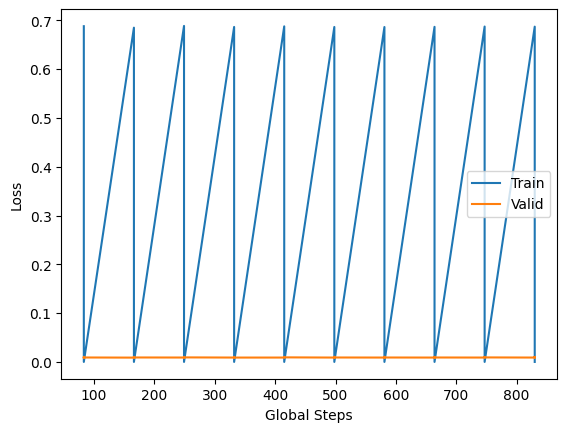

In [57]:
# Load metrics and plot
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Step 5: Evaluation
Reload the best performing model from the training run and evaluate it using the sklearn evaluation tools:

In [58]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for text, labels in test_loader:
            labels = labels.to(device)
            text = text.to(device)
            #text_len = text_len.to(device)
            output = model(text)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())

    print('Classification Report:')
    print(classification_report(y_true,y_pred,labels=[1,0], digits=4))

    cm = confusion_matrix(y_true,y_pred,labels=[1,0])
    ax = plt.subplot()
    sns.heatmap(cm,annot=True, ax=ax,cmap='Blues',fmt='d')

    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicated Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Real','Irrelevant'])
    ax.yaxis.set_ticklabels(['Real','Irrelevant'])

Model loaded from <== output/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       943
           0     0.5849    1.0000    0.7381      1329

    accuracy                         0.5849      2272
   macro avg     0.2925    0.5000    0.3691      2272
weighted avg     0.3422    0.5849    0.4318      2272



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


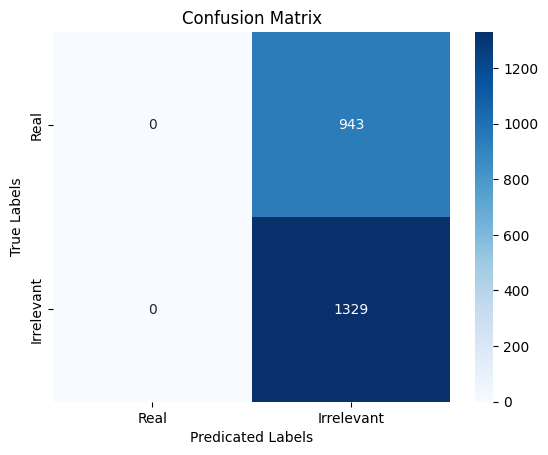

In [59]:
best_model = TEXT_LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr = 0.001)
load_checkpoint(destination_folder+'/model.pt',best_model,optimizer)
evaluate(best_model, val_loader)